In [2]:
# This notebook shows an example of how to decode the data in the EvAAL API format to pandas DataFrame.
# Please note that the format of the txt file in ../trials/ is what returned through EvAAL API in the competition.
# In the real competition in September, you need to get data throught EvAAL API.
import importlib

from sub import estimate
importlib.reload(estimate)
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from PIL import Image

plt.rcParams['figure.figsize'] = (16.0, 6.0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# LOG_FILE_PATH = "../trials/Track5_second_evaluation_01_pdr.txt"
LOG_FILE_PATH = "../trials/4_1_51_pdr.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [4]:

from collections import defaultdict

# Prepare containers for the data
data = defaultdict(list)

with open(LOG_FILE_PATH) as f:
    for line in f:
        line_contents = line.rstrip('\n').split(';')
        DATA_TYPE = line_contents[0]

        if DATA_TYPE == 'BLUE':
            data['BLUE'].append({
                'ts': float(line_contents[1]),
                'bdaddress': line_contents[2],
                'rssi': int(line_contents[4])
            })

        elif DATA_TYPE in ['ACCE', 'GYRO', 'MAGN']:
            record = {
                'ts': float(line_contents[1]),
                'accuracy': int(line_contents[6]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5])
            }
            data[DATA_TYPE].append(record)
        elif DATA_TYPE == 'POS3':
            data['POS3'].append({
                '%time': float(line_contents[1]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5]),
                'q0': float(line_contents[6]),
                'q1': float(line_contents[7]),
                'q2': float(line_contents[8]),
                'q3': float(line_contents[9]),
                'floor': line_contents[10]
            })
# Convert lists of dictionaries to dataframes
blescans = pd.DataFrame(data['BLUE'])
acc = pd.DataFrame(data['ACCE'])
gyro = pd.DataFrame(data['GYRO'])
mgf = pd.DataFrame(data['MAGN'])
gt_ref = pd.DataFrame(data['POS3'])
print(gt_ref)

acc.reset_index(inplace=True, drop=True)
gyro.reset_index(inplace=True, drop=True)
mgf.reset_index(inplace=True, drop=True)
gt_ref.reset_index(inplace=True, drop=True)

        %time          x          y         z        q0        q1        q2  \
0    0.004059  43.079905  12.163538  1.320953  0.194603  0.288317  0.324667   
1  181.660239  43.137792  12.098551  1.259271 -0.076098  0.191282  0.674619   

         q3  floor  
0  0.879542  FLU01  
1  0.708879  FLU01  


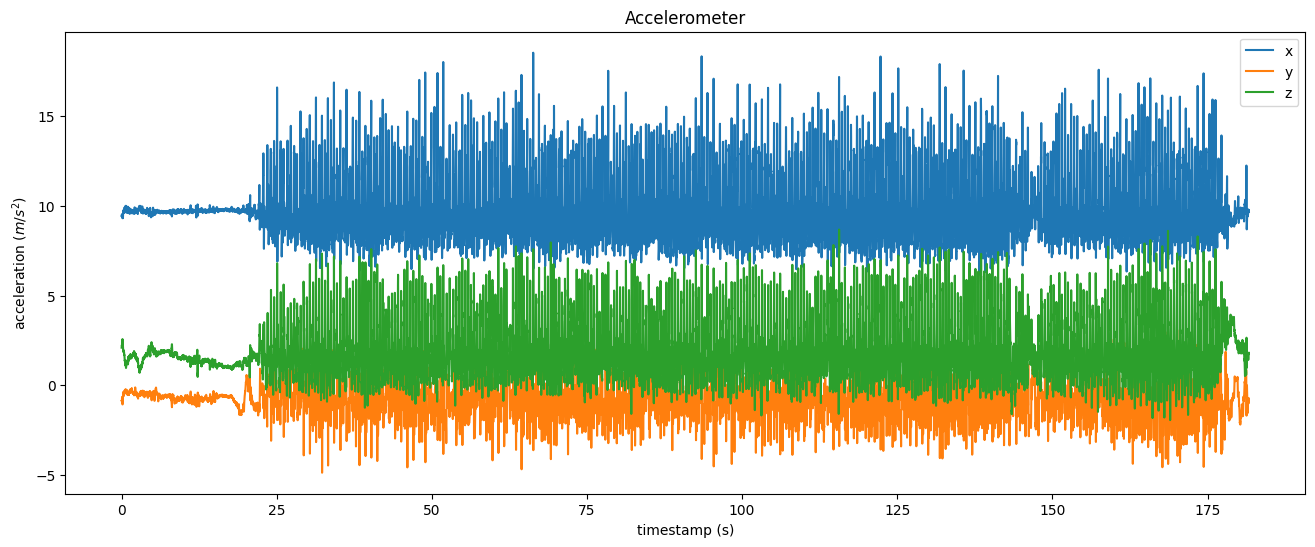

In [5]:
plt.plot(acc.ts, acc[["x", "y", "z"]], label=["x", "y", "z"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer")
plt.legend()
plt.show()


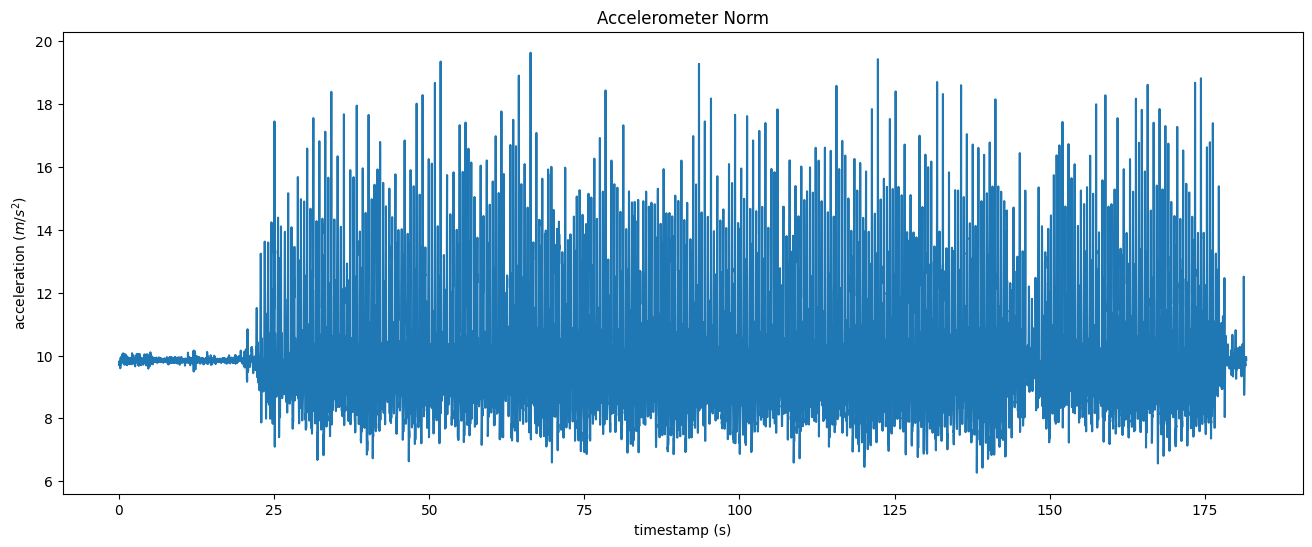

In [6]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)
acc.reset_index()

plt.plot(acc.ts, acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

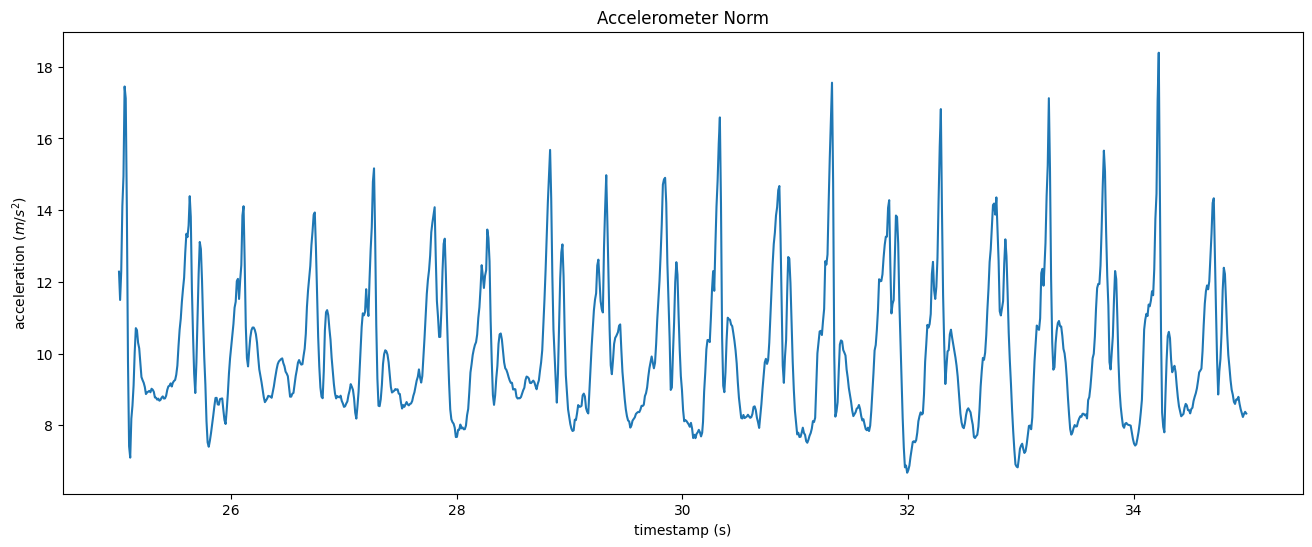

In [7]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)

# 時間が25秒以上50秒未満のデータを抽出
time_filter_acc = acc[(acc.ts >= 25) & (acc.ts < 35)]
time_filter_acc.reset_index(inplace=True, drop=True)

plt.plot(time_filter_acc.ts, time_filter_acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_44915/170683450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(


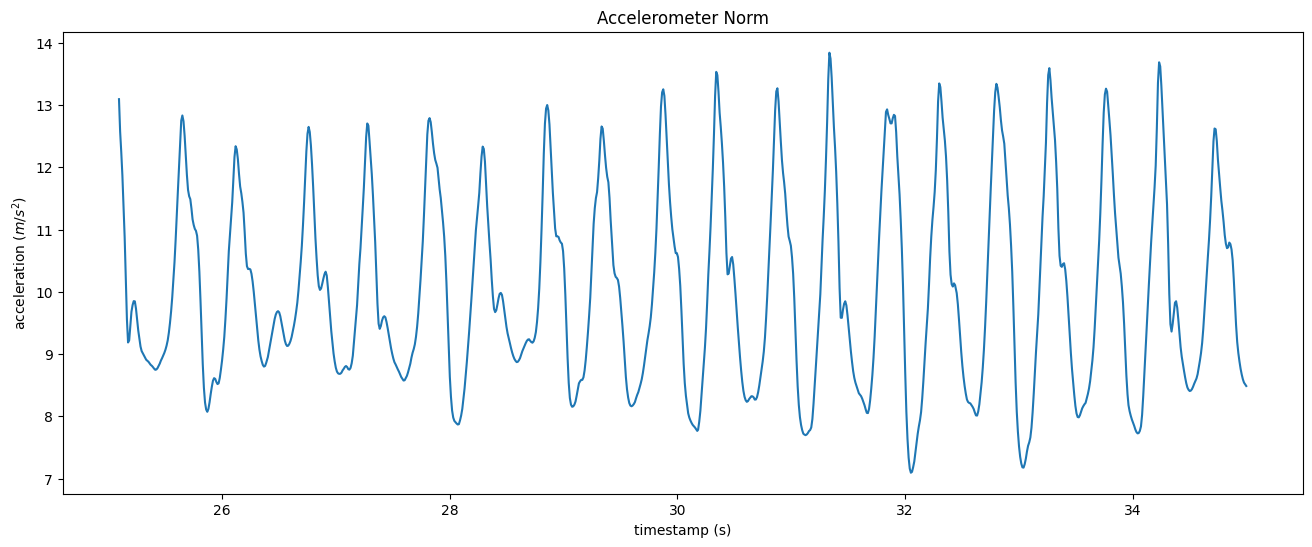

In [8]:

# 移動平均フィルターをかける
time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(
    10).mean()

plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

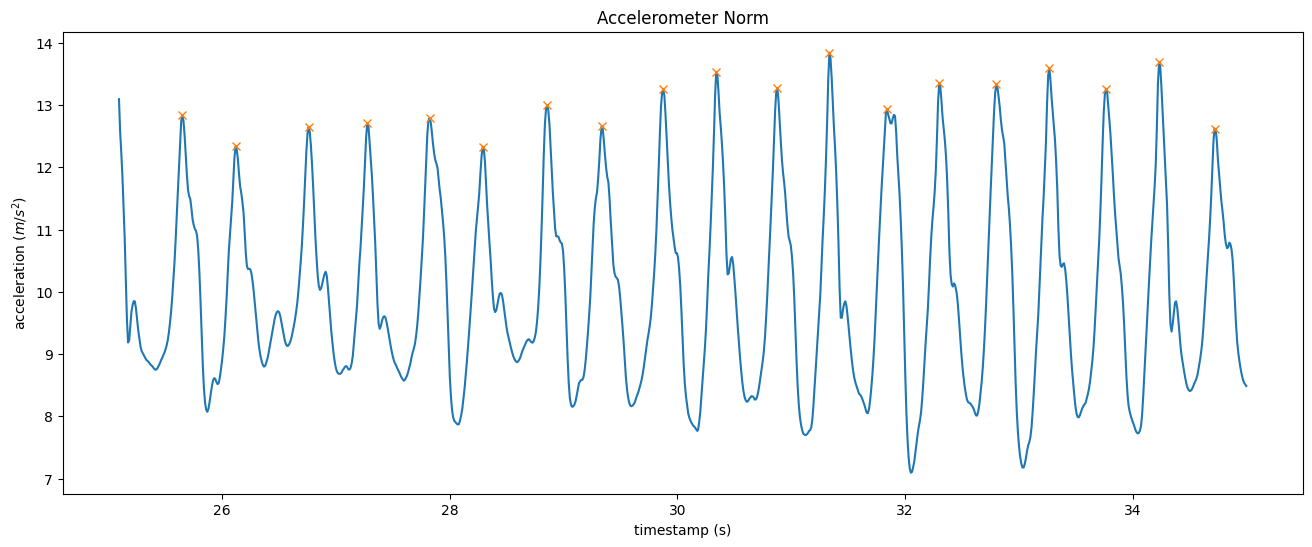

In [9]:
# ピーク検出
from scipy.signal import find_peaks

peaks, _ = find_peaks(time_filter_acc['rolling_norm'], height=12, distance=20)
plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.plot(time_filter_acc.ts[peaks],
         time_filter_acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()


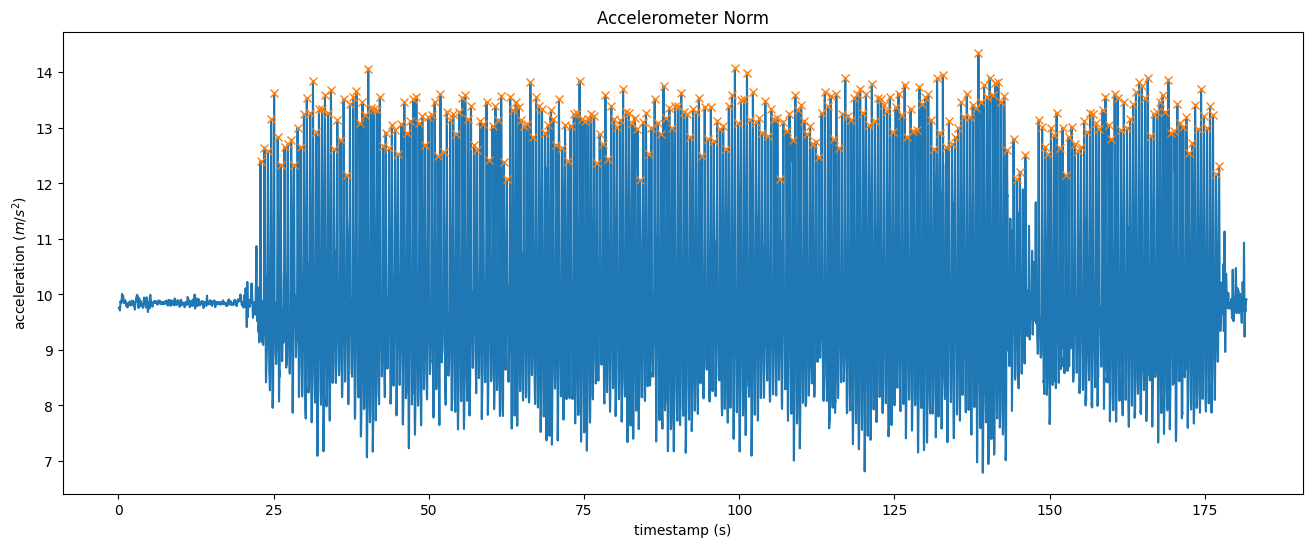

In [10]:

acc['rolling_norm'] = acc['norm'].rolling(10).mean()

peaks, _ = find_peaks(acc['rolling_norm'], height=12, distance=20)
plt.plot(acc.ts, acc['rolling_norm'])
plt.plot(acc.ts[peaks], acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()



In [11]:

gyro_in_step_timing = pd.DataFrame()
# ピーク時のジャイロの値を取得
gyro_in_step_timing = estimate.match_data(gyro, acc.ts[peaks])


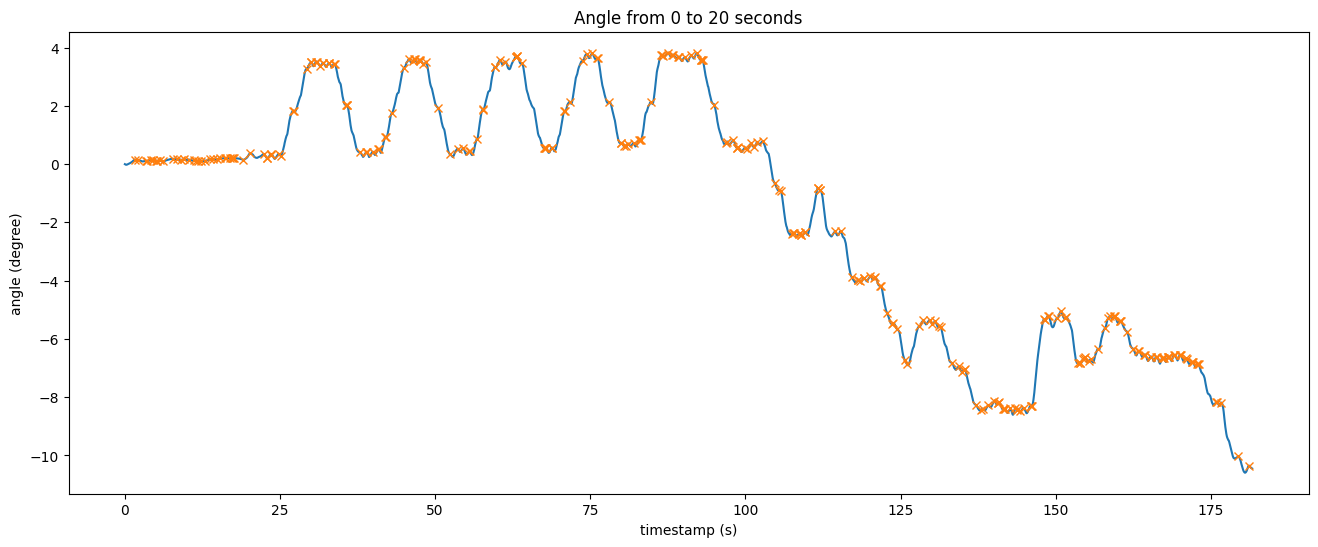

In [12]:

# # アングルの計算
# angle_df = estimate.convert_to_angle_from_gyro(
#    gyro 
# )


# # 0秒から20秒までのデータを抽出
# time_filter_angle = angle_df[(angle_df.ts >= 0) & (angle_df.ts < 20)]
# time_filter_angle.reset_index(inplace=True, drop=True)


# plt.plot(time_filter_angle.ts, time_filter_angle['x'])
# plt.xlabel("timestamp (s)")
# plt.ylabel("angle (degree)")
# plt.title("angle")
# plt.show()



# # ピークの位置をプロット
# plt.plot(angle_df.ts, angle_df['x'])
# plt.plot(angle_df.ts[peaks], angle_df['x'][peaks], "x")
# plt.xlabel("timestamp (s)")
# plt.ylabel("angle (degree)")
# plt.title("angle")
# plt.show()


import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 角度データフレームの生成
angle_df = estimate.convert_to_angle_from_gyro(gyro)

# 0秒から20秒までのデータを抽出
time_filtered_df = angle_df

# フィルタリングされたデータでピーク値の検出
peaks, _ = find_peaks(time_filtered_df['x'])

# フィルタリングされたデータのプロット
plt.plot(time_filtered_df.ts, time_filtered_df['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle (degree)")
plt.title("Angle from 0 to 20 seconds")

# ピークの位置をプロット
plt.plot(time_filtered_df.ts.iloc[peaks], time_filtered_df['x'].iloc[peaks], "x")
plt.show()

In [13]:
peaks, _ = find_peaks(acc['rolling_norm'], height=12)
print(peaks)

[ 2300  2363  2419  2472  2520  2578  2625  2689  2741  2796  2843  2900
  2948  3002  3049  3103  3149  3200  3206  3246  3296  3343  3393  3440
  3489  3543  3595  3645  3694  3748  3802  3853  3903  3950  3999  4044
  4095  4140  4190  4231  4283  4326  4381  4426  4479  4526  4581  4627
  4678  4684  4725  4776  4823  4873  4919  4965  5018  5071  5119  5166
  5212  5265  5316  5370  5420  5471  5518  5569  5614  5662  5707  5761
  5806  5860  5906  5959  6006  6056  6102  6152  6196  6240  6288  6342
  6387  6432  6478  6519  6571  6620  6668  6714  6762  6811  6857  6906
  6913  6952  6997  7003  7040  7089  7097  7132  7184  7229  7276  7319
  7371  7417  7465  7512  7560  7566  7606  7653  7700  7744  7791  7839
  7883  7929  7978  8025  8074  8124  8169  8218  8263  8310  8317  8355
  8402  8410  8444  8495  8540  8586  8627  8681  8730  8778  8824  8871
  8918  8967  8969  9012  9063  9111  9160  9206  9256  9302  9350  9396
  9441  9491  9541  9590  9638  9692  9743  9790  9

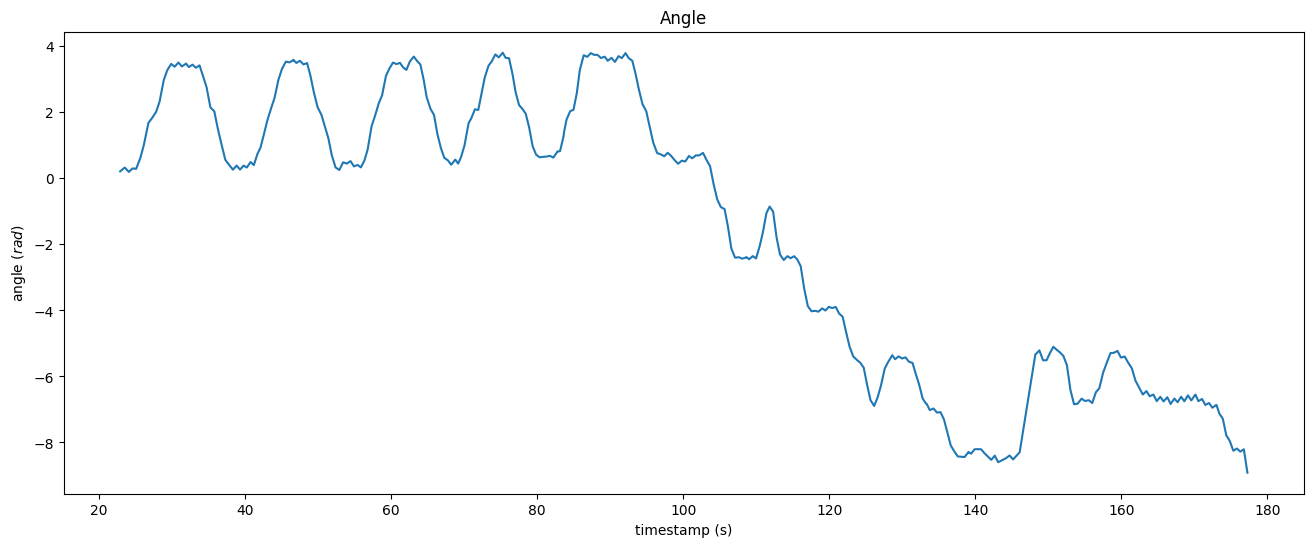

In [14]:

# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()
angle_in_step_timing= estimate.match_data(angle_df, acc.ts[peaks])




plt.plot(angle_in_step_timing.ts, angle_in_step_timing['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

FLU01
[ 2300  2363  2419  2472  2520  2578  2625  2689  2741  2796  2843  2900
  2948  3002  3049  3103  3149  3200  3206  3246  3296  3343  3393  3440
  3489  3543  3595  3645  3694  3748  3802  3853  3903  3950  3999  4044
  4095  4140  4190  4231  4283  4326  4381  4426  4479  4526  4581  4627
  4678  4684  4725  4776  4823  4873  4919  4965  5018  5071  5119  5166
  5212  5265  5316  5370  5420  5471  5518  5569  5614  5662  5707  5761
  5806  5860  5906  5959  6006  6056  6102  6152  6196  6240  6288  6342
  6387  6432  6478  6519  6571  6620  6668  6714  6762  6811  6857  6906
  6913  6952  6997  7003  7040  7089  7097  7132  7184  7229  7276  7319
  7371  7417  7465  7512  7560  7566  7606  7653  7700  7744  7791  7839
  7883  7929  7978  8025  8074  8124  8169  8218  8263  8310  8317  8355
  8402  8410  8444  8495  8540  8586  8627  8681  8730  8778  8824  8871
  8918  8967  8969  9012  9063  9111  9160  9206  9256  9302  9350  9396
  9441  9491  9541  9590  9638  9692  9743  9

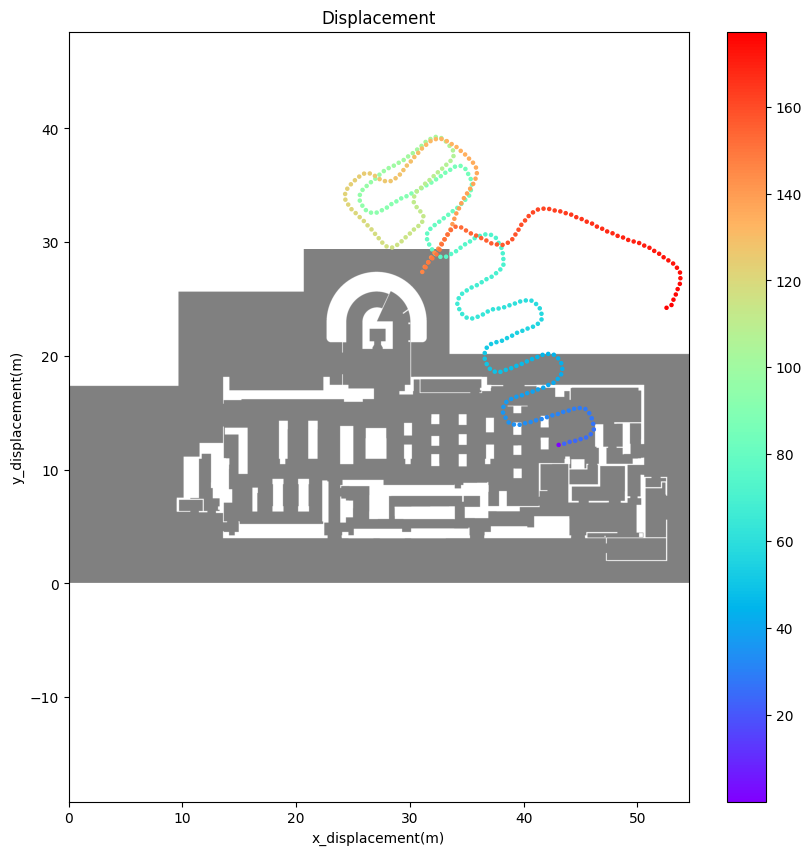

In [15]:
# 1 pixel of bmp represents 0.01 m
dx = 0.01
dy = 0.01

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp")


floor_name = gt_ref['floor'].values[0]
print(floor_name)

estimate.plot_map(map_dict,floor_name, dx, dy)

print(peaks)

peek_angle = estimate.convert_to_peek_angle(gyro,acc,peaks)
print(peek_angle)
cumulative_displacement_df = estimate.calculate_cumulative_displacement(peek_angle.ts, peek_angle['x'], 0.5, {"x":gt_ref.x[0],"y":gt_ref.y[0]},gt_ref['%time'][0])

plt.colorbar(
    plt.scatter(cumulative_displacement_df.x_displacement, cumulative_displacement_df.y_displacement, c=cumulative_displacement_df.ts, cmap="rainbow",s=5))

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



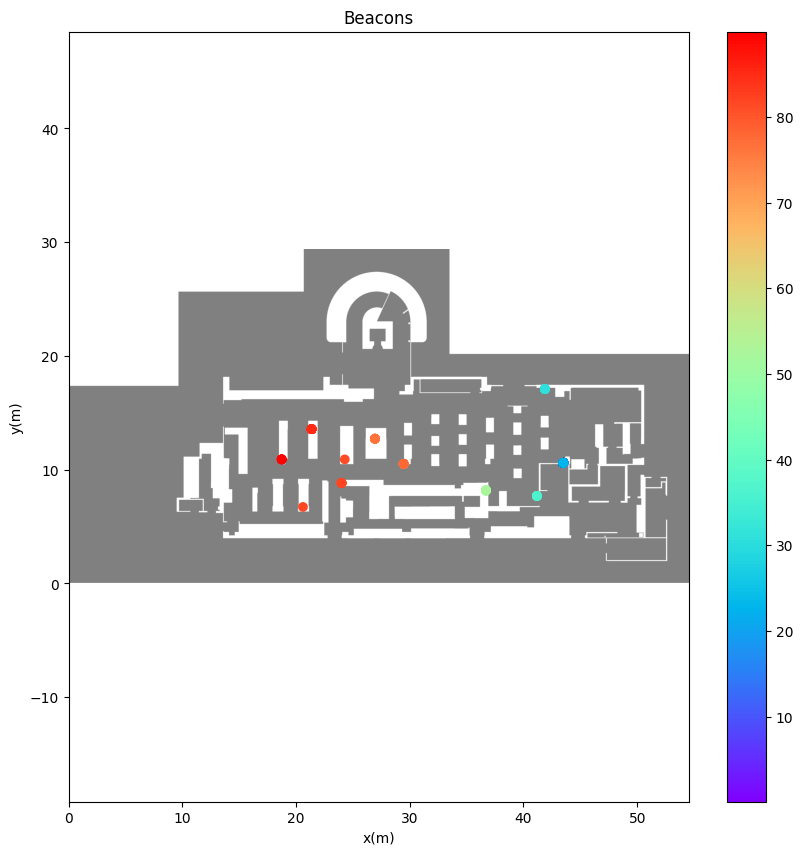

In [16]:

import numpy as np
import pandas as pd


# 軌跡前半の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索
# これは軌跡前半はドリフトが乗りづらいため
#時間全体の中央を変数に入れる

center_of_time = blescans.tail(1)['ts'].values[0]/2

first_half_strong_blescans= estimate.filter_strong_blescans(blescans,center_of_time,-76)
merged_strong_blescans_first_half = estimate.load_beacons_and_merge(BEACON_LIST_PATH, first_half_strong_blescans)


# マップ上にビーコンの位置をプロット
estimate.plot_map(map_dict,floor_name, dx, dy)

plt.colorbar(
    plt.scatter(merged_strong_blescans_first_half.x, merged_strong_blescans_first_half.y, c=merged_strong_blescans_first_half['ts'], cmap="rainbow"))

plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("Beacons")
plt.show()



     index         ts          bdaddress  rssi          x          y  height  \
0        6   0.076196  C0:1C:4D:44:32:56   -73  43.500000  10.600000    1.75   
1      360   4.609002  C0:1C:4D:44:32:56   -75  43.500000  10.600000    1.75   
2      370   4.707464  C0:1C:4D:44:32:56   -74  43.500000  10.600000    1.75   
3      379   4.810954  C0:1C:4D:44:32:56   -73  43.500000  10.600000    1.75   
4      394   5.027880  C0:1C:4D:44:32:56   -73  43.500000  10.600000    1.75   
5      408   5.234949  C0:1C:4D:44:32:56   -73  43.500000  10.600000    1.75   
6      418   5.336859  C0:1C:4D:44:32:56   -73  43.500000  10.600000    1.75   
7      428   5.439220  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
8      438   5.547211  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
9      446   5.653872  C0:1C:4D:44:32:56   -72  43.500000  10.600000    1.75   
10     452   5.754841  C0:1C:4D:44:32:56   -71  43.500000  10.600000    1.75   
11     457   5.864267  C0:1C:4D:44:32:56

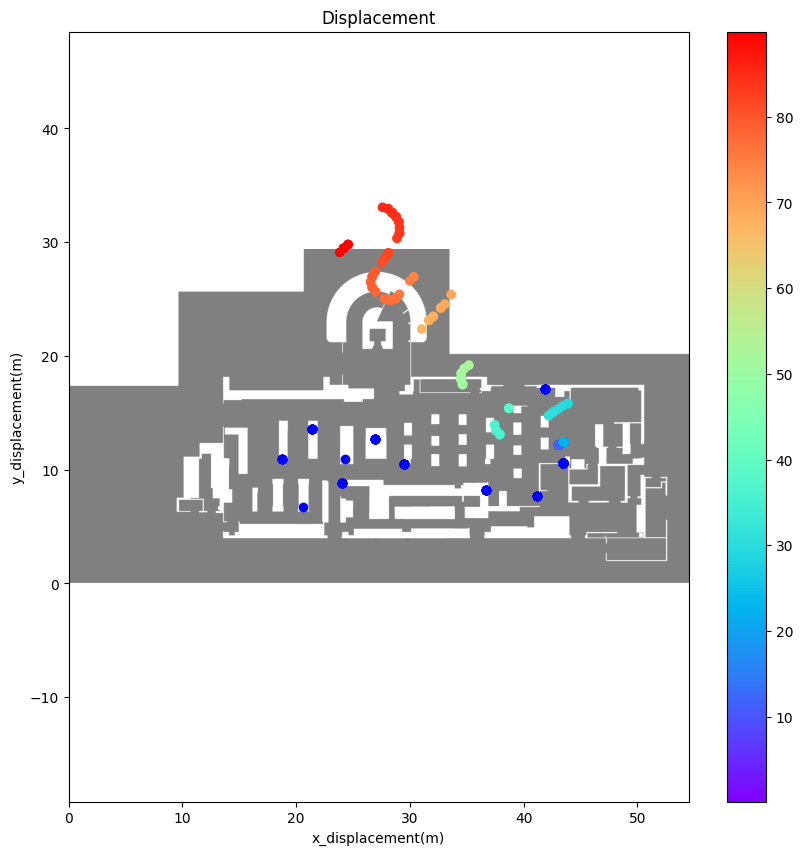

In [17]:

rotated_cumulative_displacement_df =estimate.rotate_cumulative_displacement(
    cumulative_displacement_df, 0.3,         
    {"x": gt_ref.x[0], "y": gt_ref.y[0]})




# 同じ bdaddress, x, y を持つデータをグループ化
merged_df = pd.merge_asof(merged_strong_blescans_first_half, rotated_cumulative_displacement_df, on='ts',direction="nearest")

print(merged_df)

# マップ上にx_displacement,y_displacementとビーコンの位置をプロット
estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(merged_df.x_displacement, merged_df.y_displacement, c=merged_df['ts'], cmap="rainbow"))
plt.scatter(merged_df.x, merged_df.y, c="blue")

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

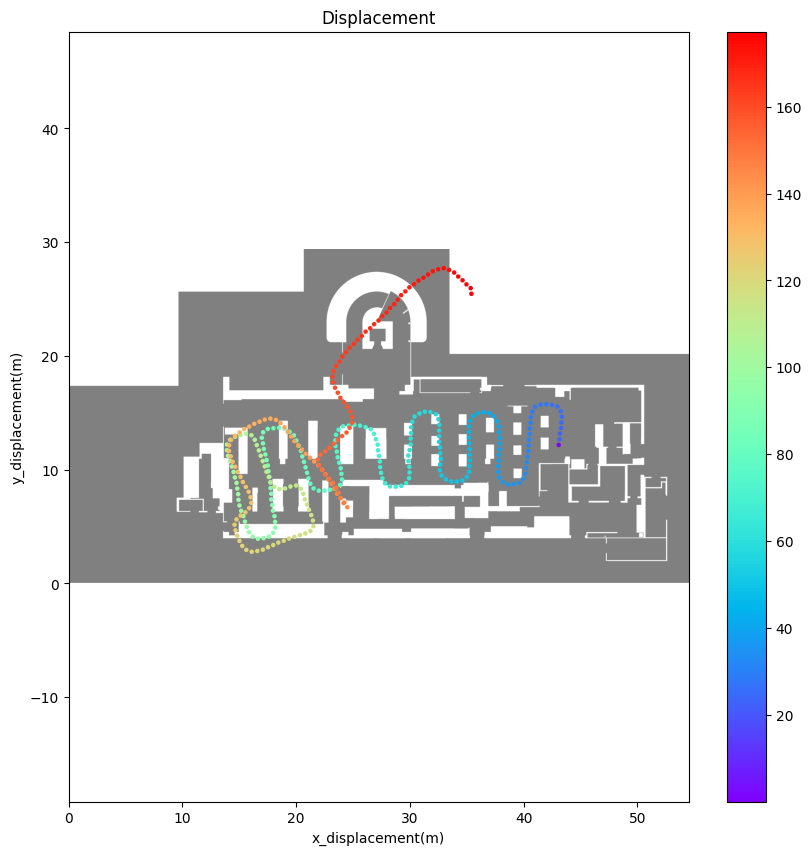

In [18]:

angle=estimate.search_optimal_angle(cumulative_displacement_df,gt_ref,merged_strong_blescans_first_half)

rotate_by_first_half_angle= pd.DataFrame({
    "ts":angle_in_step_timing.ts,
    "x":angle_in_step_timing.x+angle
})

rotate_by_first_half_angle_displacement = estimate.calculate_cumulative_displacement(
    rotate_by_first_half_angle.ts, rotate_by_first_half_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_first_half_angle_displacement.x_displacement, rotate_by_first_half_angle_displacement.y_displacement,
                c=rotate_by_first_half_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()


               ts         x
2300    22.887179  1.401744
2363    23.518216  1.515903
2419    24.075389  1.385037
2472    24.600236  1.491761
2520    25.076593  1.476142
2578    25.653061  1.804121
2625    26.120688  2.188270
2689    26.761847  2.869440
2741    27.276752  3.020989
2796    27.823976  3.208122
2843    28.290371  3.514464
2900    28.856890  4.159514
2948    29.334467  4.460915
3002    29.876127  4.655530
3049    30.341279  4.570797
3103    30.878553  4.697637
3149    31.335014  4.578439
3200    31.841835  4.652891
3206    31.901533  4.668236
3246    32.299513  4.559374
3296    32.801381  4.633521
3343    33.266530  4.537994
3393    33.764006  4.611120
3440    34.230407  4.288816
3489    34.717325  3.955161
3543    35.254599  3.335927
3595    35.776401  3.223564
3645    36.271380  2.686217
3694    36.758907  2.227964
3748    37.294939  1.749284
3802    37.831605  1.592493
3853    38.339031  1.452183
3903    38.840892  1.576727
3950    39.306041  1.454951
3999    39.793567  1

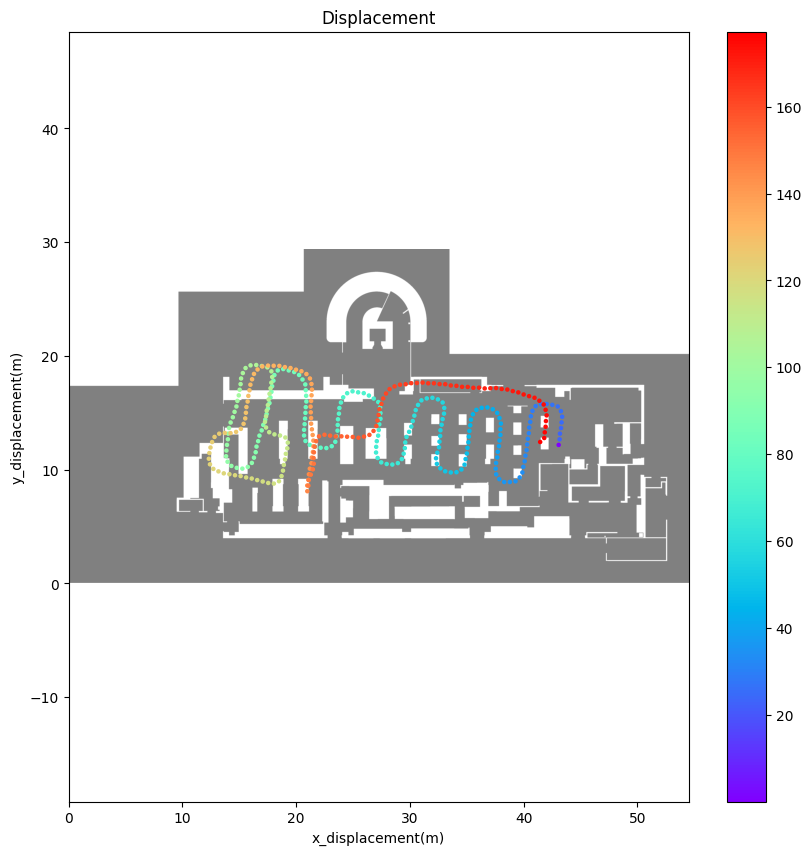

In [19]:
print(rotate_by_first_half_angle)

optimal_drift_and_euclidean=estimate.search_optimal_drift_from_angle(rotate_by_first_half_angle,gt_ref)


first_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_first_half_angle.ts,
    "x":rotate_by_first_half_angle.x-optimal_drift_and_euclidean['drift']*(rotate_by_first_half_angle.ts-rotate_by_first_half_angle.ts.iloc[0])
})

# first_time_remove_drift_angle= pd.DataFrame({
#     "ts":rotate_by_first_half_angle.ts,
#     "x":rotate_by_first_half_angle.x-0.002999999999999989*(rotate_by_first_half_angle.ts-rotate_by_first_half_angle.ts.iloc[0])
# })


first_time_remove_drift_angle_displacement = estimate.calculate_cumulative_displacement(
    first_time_remove_drift_angle.ts, first_time_remove_drift_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(first_time_remove_drift_angle_displacement.x_displacement, first_time_remove_drift_angle_displacement.y_displacement,
                c=first_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



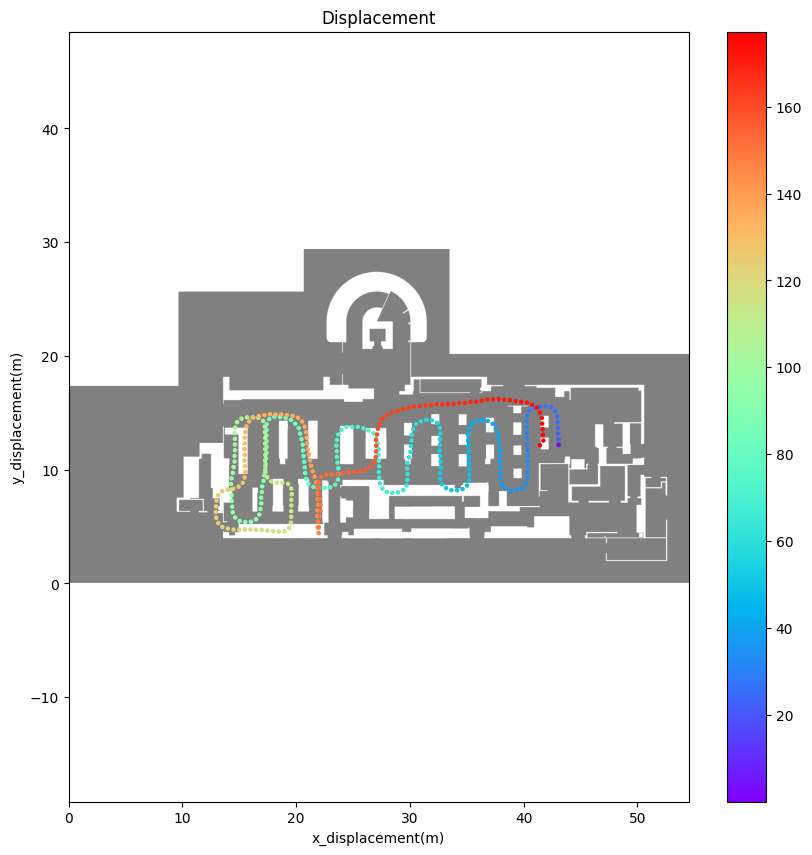

In [20]:
# 軌跡全体の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索見つける
overall_strong_blescans= estimate.filter_strong_blescans(blescans,blescans.tail(1)['ts'].values[0],-76)
merged_strong_blescans_overall = estimate.load_beacons_and_merge(BEACON_LIST_PATH, overall_strong_blescans)

overall_strong_ble_angle = estimate.search_optimal_angle(first_time_remove_drift_angle_displacement,gt_ref,merged_strong_blescans_overall)

rotate_by_overall_strong_ble_angle= pd.DataFrame({
    "ts":first_time_remove_drift_angle.ts,
    "x":first_time_remove_drift_angle.x+overall_strong_ble_angle
})


rotate_by_overall_strong_ble_angle_displacement = estimate.calculate_cumulative_displacement(
    rotate_by_overall_strong_ble_angle.ts, rotate_by_overall_strong_ble_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_overall_strong_ble_angle_displacement.x_displacement, rotate_by_overall_strong_ble_angle_displacement.y_displacement,
                c=rotate_by_overall_strong_ble_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



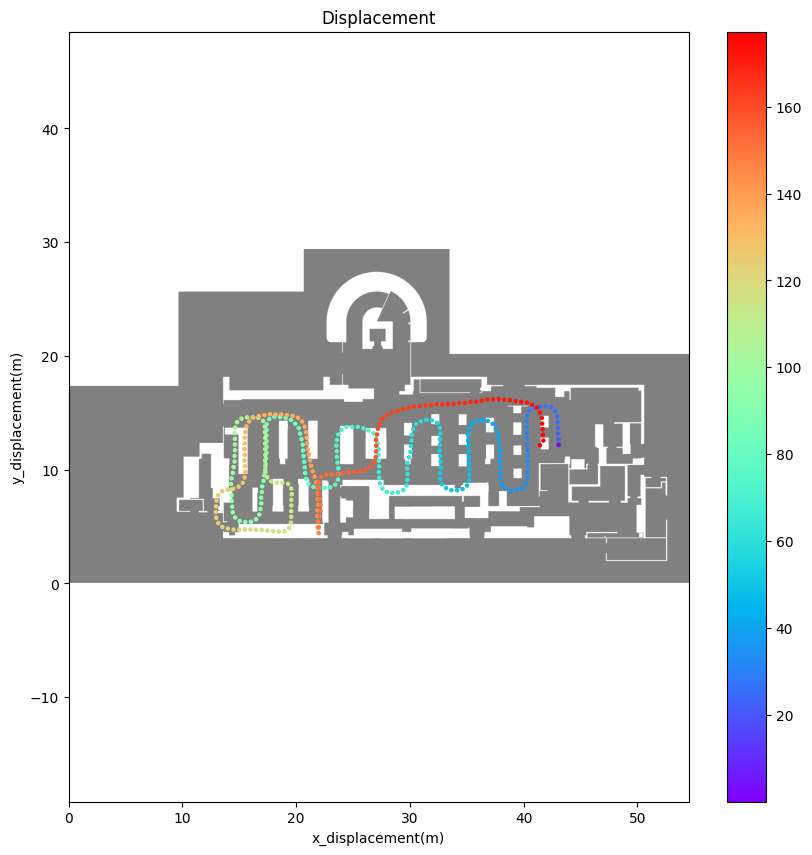

In [21]:

second_optimal_drift_and_euclidean=estimate.search_optimal_drift_from_angle(rotate_by_overall_strong_ble_angle,gt_ref)

second_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_overall_strong_ble_angle.ts,
    "x":rotate_by_overall_strong_ble_angle.x-second_optimal_drift_and_euclidean['drift']*(rotate_by_overall_strong_ble_angle.ts-rotate_by_overall_strong_ble_angle.ts.iloc[0])
})

second_time_remove_drift_angle_displacement = estimate.calculate_cumulative_displacement(
    second_time_remove_drift_angle.ts, second_time_remove_drift_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(second_time_remove_drift_angle_displacement.x_displacement, second_time_remove_drift_angle_displacement.y_displacement,
                c=second_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()





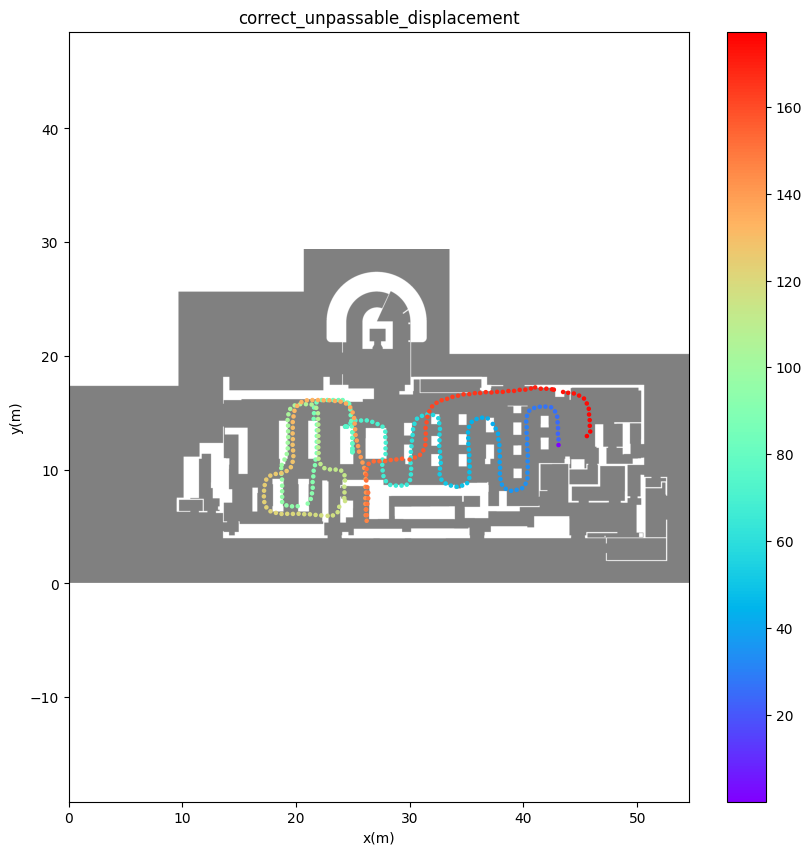

In [22]:

np.set_printoptions(threshold=np.inf)

correct_unpassable_displacement = estimate.correct_unpassable_points(second_time_remove_drift_angle_displacement[second_time_remove_drift_angle_displacement['ts']<180], map_dict, floor_name, dx, dy)

estimate.plot_map(
    map_dict,
    floor_name,
    dx,
    dy,
)

plt.colorbar(
    plt.scatter(
        correct_unpassable_displacement['x_displacement'],
        correct_unpassable_displacement['y_displacement'],
        c=correct_unpassable_displacement['ts'],
        cmap='rainbow',
        s=5
    )
)


plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.title('correct_unpassable_displacement')
plt.show()



output_df = pd.DataFrame({
    'ts': correct_unpassable_displacement['ts'],
    'x': correct_unpassable_displacement['x_displacement'],
    'y': correct_unpassable_displacement['y_displacement'],
    'floor': floor_name
})


output_df.to_csv('8_1_est.csv', index=False, header=False)

